In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import shap
shap.initjs()

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split

import xgboost as xgb
from xgboost import plot_importance

pd.options.mode.chained_assignment = None

sns.set()

In [25]:
from xgboost import plot_importance

In [2]:
df = pd.read_csv('../data/raw/training_v2.csv')

In [3]:
# drop columns with id (don't have an influence on the model)
df.drop('encounter_id', axis=1, inplace=True)
df.drop('patient_id', axis=1, inplace=True)
df.drop('hospital_id', axis=1, inplace=True)
df.drop('icu_id', axis=1, inplace=True)

In [4]:
col_list = []
with open("../data/raw/del_columns.txt", "r") as f:
    for line in f:
        col_list.append(line[:-1])
        
df.drop(columns=col_list, inplace=True, axis=1)

In [5]:
def preprocess_features(df):
    # 25 genders are nan => replace them with 'M'
    df['gender'] = df['gender'].fillna(df['gender'].value_counts().index[0])
    df['gender'] = df['gender'].map({'M': 0, 'F': 1})
    
    df['ethnicity'] = df['ethnicity'].fillna("Other/Unknown")
    
    und_diag = {"Undefined diagnoses": "Undefined Diagnoses"}
    df["apache_2_bodysystem"].replace(und_diag, inplace = True)
    
    df["age"].fillna(int(df["age"].mean()), inplace=True)
    d = {range(1, 50): 1, range(50, 65): 2, range(65, 75): 3, range(75, 100): 4}
    df["age"] = df["age"].apply(lambda x: next((v for k, v in d.items() if x in k), 0))
    
    df.dropna(subset=['heart_rate_apache', 'temp_apache'], inplace=True)
    
    d1 = {range(25, 80): 1, range(80, 120): 2, range(120, 150): 3, range(150, 180): 4, range(180, 200): 5}
    df["heart_rate_apache"] = df["heart_rate_apache"].apply(lambda x: next((v for k, v in d1.items() if x in k), 0))

    df = pd.get_dummies(df, columns=["age", "heart_rate_apache"])
    
    d2 = {range(int(df["temp_apache"].min()), 37): 0, range(37, int(df["temp_apache"].max())+1): 1}
    df["temp_apache"] = df["temp_apache"].apply(lambda x: next((v for k, v in d2.items() if x in k), 0))
    
    df["urineoutput_apache"].fillna(df["urineoutput_apache"].mean(), inplace=True)
    
    # normalize urineoutput_apache
    x = df[['urineoutput_apache']].values.astype(float)
    min_max_scaler = MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df["urineoutput_apache"] = x_scaled
    
    cat_columns = ["ethnicity",
                   "apache_3j_bodysystem", 
                   "apache_2_bodysystem"]

    df = pd.get_dummies(df, columns=cat_columns)

    return df

In [6]:
def evaluate(y_true, scores, preds):
    acc = accuracy_score(y_true, preds)
    precision = precision_score(y_true, preds)
    recall = recall_score(y_true, preds)
    f1 = f1_score(y_true, preds)
    roc_auc = roc_auc_score(y_true, scores)
    auprc = average_precision_score(y_true, scores)
    
    print("Accuracy:  {:.3f}".format(acc))
    print("Precision: {:.3f}".format(precision))
    print("Recall:    {:.3f}".format(recall))
    print("F1-score:  {:.3f}".format(f1))
    print("ROCAUC:    {:.3f}".format(roc_auc))
    print("AUPRC:     {:.3f}".format(auprc))

In [7]:
def plot_roc_curve(y_test, preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [8]:
clean_df = preprocess_features(df)

In [9]:
clean_df.shape

(87554, 122)

In [10]:
y = clean_df.hospital_death
X = clean_df.drop(columns="hospital_death")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [13]:
df = X_train.join(y_train)
pos_df = df[df.hospital_death == 1]
neg_df = df[df.hospital_death == 0].sample(n=pos_df.shape[0], random_state=1)

df_balanced = pd.concat([pos_df, neg_df])
df_balanced = df_balanced.sample(frac=1).reset_index(drop=True)

In [16]:
y_train = df_balanced.hospital_death
X_train = df_balanced.drop(columns="hospital_death")

In [18]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

model = xgb.XGBClassifier(n_estimators=128,
                          learning_rate=0.1,
                          max_depth=6,
                          min_child_weight=2,
                          colsample_bytree=0.7,
                          subsample=1,
                          random_state=42,
                          scale_pos_weight=scale_pos_weight,
                          n_jobs=-1)

model.fit(X_train, y_train, verbose=True)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints=None,
              n_estimators=128, n_jobs=-1, num_parallel_tree=1,
              objective='binary:logistic', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1.0, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [19]:
y_true = y_test.values

y_score = model.predict_proba(X_test)
y_pred = model.predict(X_test)

evaluate(y_true, y_score[:, 1], y_pred)

Accuracy:  0.801
Precision: 0.270
Recall:    0.808
F1-score:  0.405
ROCAUC:    0.889
AUPRC:     0.512


Text(0.5, 1.0, '2-class Precision-Recall curve')

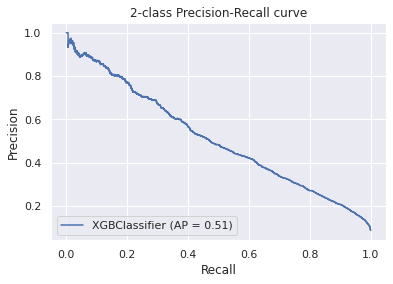

In [20]:
disp = plot_precision_recall_curve(model, X_test, y_true)
disp.ax_.set_title('2-class Precision-Recall curve')

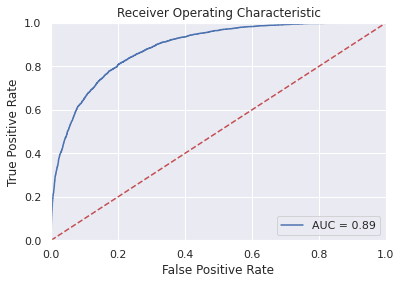

In [21]:
plot_roc_curve(y_true, y_score[:, 1])

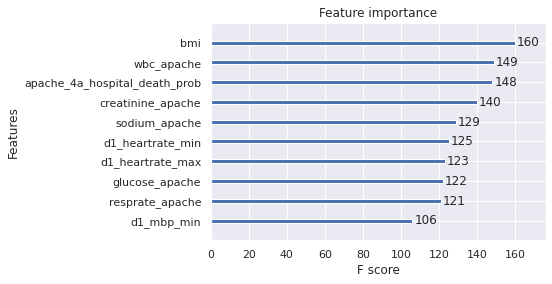

In [30]:
plot_importance(model, max_num_features=10)
plt.show()

In [22]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


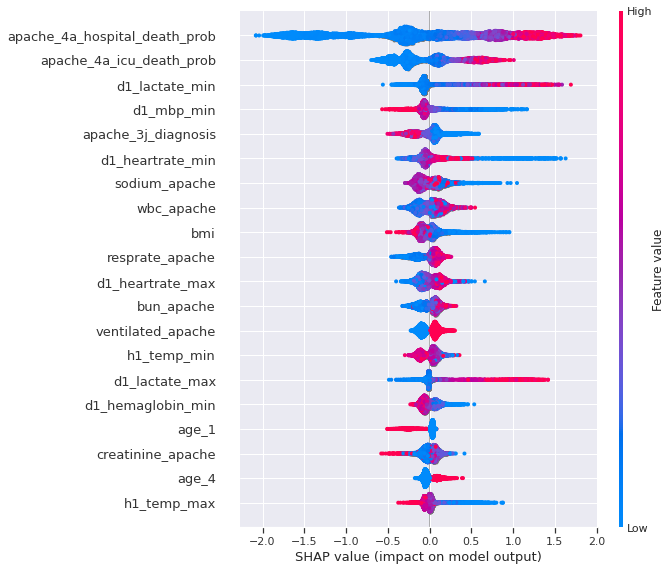

In [23]:
f = plt.figure()
shap.summary_plot(shap_values, X_train)
f.savefig("../reports/2.2_xgboost_summary_plot.png", bbox_inches='tight', dpi=600)

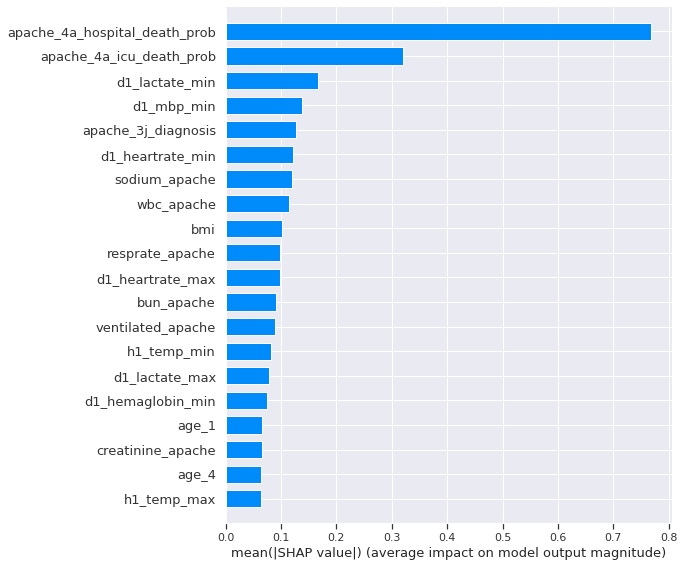

In [24]:
shap.summary_plot(shap_values, X_train, plot_type="bar")